# Nearest Neighbors

When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically
* Decide on a notion of similarity
* Find the documents that are most similar 

In the assignment you will
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

## Import necessary packages

As usual we need to first import the Python packages that we will need.

In [51]:
import json
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Load Wikipedia dataset

We will be using the same dataset of Wikipedia pages that we used in the Machine Learning Foundations course (Course 1). Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).  

In [2]:
wiki = pd.read_csv('people_wiki.csv')

In [3]:
wiki

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...
...,...,...,...
59066,<http://dbpedia.org/resource/Olari_Elts>,Olari Elts,olari elts born april 27 1971 in tallinn eston...
59067,<http://dbpedia.org/resource/Scott_F._Crago>,Scott F. Crago,scott francis crago born july 26 1963 twin bro...
59068,<http://dbpedia.org/resource/David_Cass_(footb...,David Cass (footballer),david william royce cass born 27 march 1962 in...
59069,<http://dbpedia.org/resource/Keith_Elias>,Keith Elias,keith hector elias born february 3 1972 in lac...


## Extract word count vectors

For your convenience, we extracted the word count vectors from the dataset. The vectors are packaged in a sparse matrix, where the i-th row gives the word count vectors for the i-th document. Each column corresponds to a unique word appearing in the dataset. The mapping between words and integer indices are given in people_wiki_map_index_to_word.gl.

In [4]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

word_count = load_sparse_csr('people_wiki_word_count.npz')

In [5]:
with open('people_wiki_map_index_to_word.json', 'r') as f:
    map_index_to_word = json.load(f)

## Find nearest neighbors

Let's start by finding the nearest neighbors of the Barack Obama page using the word count vectors to represent the articles and Euclidean distance to measure distance.  For this, we will use scikit-learn's implementation of k-nearest neighbors. We first create an instance of the NearestNeighbor class, specifying the model parameters. Then we call the fit() method to attach the training set.

In [6]:
model = NearestNeighbors(metric='euclidean', algorithm='brute')
model.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

Run the following cell to obtain the row number for Obama's article:

In [7]:
wiki[wiki['name'] == 'Barack Obama']

,URI,name,text
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...


which locates Obama's article at index 35817.

Let us run the k-nearest neighbor algorithm with Obama's article. Since the NearestNeighbor class expects a vector, we pass the 35817th row of word_count vector.

In [8]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10) # 1st arg: word count vector

The query returns the indices of and distances to the 10 nearest neighbors. To display the indices and distances together with the article name, run:

In [9]:
neighbours = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
neighbours.set_index('id').join(wiki).reset_index().sort_values('distance')[['id', 'name', 'distance']]

,id,name,distance
0,35817,Barack Obama,0.000000
1,24478,Joe Biden,33.075671
2,28447,George W. Bush,34.394767
3,35357,Lawrence Summers,36.152455
4,14754,Mitt Romney,36.166283
5,13229,Francisco Barrio,36.331804
6,31423,Walter Mondale,36.400549
7,22745,Wynn Normington Hugh-Jones,36.496575
8,36364,Don Bonker,36.633318
9,9210,Andy Anstett,36.959437


## Interpreting the nearest neighbours

All of the 10 people are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians.

* Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
* Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.
* Wynn Normington Hugh-Jones is a former British diplomat and Liberal Party official.
* Andy Anstett is a former politician in Manitoba, Canada.

Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

For instance, let's find out why Francisco Barrio was considered a close neighbor of Obama. To do this, let's look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages.

First, run the following cell to obtain the word_count column, which represents the word count vectors in the dictionary form. This way, we can quickly recognize words of great importance.

In [10]:
def unpack_dict(matrix, map_index_to_word):
    table = sorted(map_index_to_word, key=map_index_to_word.get)    
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                data[indptr[i]:indptr[i+1]].tolist())} \
            for i in range(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

In [11]:
wiki

,URI,name,text,word_count
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,"{'fantasticrottensteiner': 1, 'waidmannsfeld':..."
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '..."
...,...,...,...,...
59066,<http://dbpedia.org/resource/Olari_Elts>,Olari Elts,olari elts born april 27 1971 in tallinn eston...,"{'orchestraolaris': 1, 'ivth': 1, 'nyyd': 1, '..."
59067,<http://dbpedia.org/resource/Scott_F._Crago>,Scott F. Crago,scott francis crago born july 26 1963 twin bro...,"{'procushion': 1, '5088376': 1, 'trafton': 3, ..."
59068,<http://dbpedia.org/resource/David_Cass_(footb...,David Cass (footballer),david william royce cass born 27 march 1962 in...,"{'3257': 1, '15696': 1, 'grewcock': 1, 'orient..."
59069,<http://dbpedia.org/resource/Keith_Elias>,Keith Elias,keith hector elias born february 3 1972 in lac...,"{'recordselias': 1, 'cochampionship': 1, 'xfl'..."


To make things even easier, we provide a utility function that displays a dictionary in tabular form:

In [12]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    word_count_dict = row['word_count'].to_dict()
    word_count_table = pd.DataFrame(word_count_dict).reset_index()
    word_count_table.columns = ['word', 'count']
    word_count_table.sort_values(by='count', ascending=False, inplace=True)
    return word_count_table

obama_words = top_words('Barack Obama')
obama_words

,word,count
245,the,40
118,in,30
31,and,21
165,of,18
248,to,14
...,...,...
112,hook,1
114,husen,1
115,hussein,1
116,ii,1


In [13]:
barrio_words = top_words('Francisco Barrio')
barrio_words

,word,count
204,the,36
147,of,24
23,and,18
102,in,17
95,he,10
...,...,...
86,francisco,1
88,good,1
89,governance,1
91,governors,1


Let's extract the list of most frequent words that appear in both Obama's and Barrio's documents. We've so far sorted all words from Obama and Barrio's articles by their word frequencies. We will now use a dataframe operation known as join. The join operation is very useful when it comes to playing around with data: it lets you combine the content of two tables using a shared column (in this case, the word column). See the documentation

 for more details.

For instance, running

In [14]:
combined_words = obama_words.join(barrio_words.set_index('word'), on='word', how='inner', lsuffix='_l', rsuffix='_r')
combined_words.columns = ['word', 'obama', 'barrio']

Note. The join operation does not enforce any particular ordering on the shared column. So to obtain, say, the five common words that appear most often in Obama's article, sort the combined table by the Obama column. Don't forget ascending=False to display largest counts first.

In [15]:
combined_words.sort_values(by='obama', ascending=False, inplace=True)
combined_words.head(10)

,word,obama,barrio
245,the,40,36
118,in,30,17
31,and,21,18
165,of,18,24
248,to,14,9
109,his,11,5
20,a,7,6
107,he,7,10
33,as,6,5
263,was,5,4


**Quiz Question**. Among the words that appear in both Barack Obama and Francisco Barrio, take the 5 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

Hint:
- Refer to the previous paragraph for finding the words that appear in both articles. Sort the common words by their frequencies in Obama's article and take the largest five. 
- Each word count vector is a Python dictionary. For each word count vector in the dataframe, you'd have to check if the set of the 5 common words is a subset of the keys of the word count vector. Complete the function has_top_words to accomplish the task. 
- Convert the list of top 5 words into set using the syntax "set(common_words)", where common_words is a Python list.
- Extract the list of keys of the word count dictionary by calling the keys() method. 
- Convert the list of keys into a set as well. 
- Use issubset() method to check if all 5 words are among the keys. 
- Now apply the has_top_words function on every row of the dataframe. 
- Compute the sum of the result column to obtain the number of articles containing all the 5 top words. 

In [30]:
common_words = set(combined_words.word[:5])

def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return common_words.issubset(unique_words)

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

# use has_top_words column to answer the quiz question
sum(wiki.has_top_words)

56066

**Checkpoint**. Check your `has_top_words` function on two random articles:

In [38]:
print('Output from your function:', has_top_words(wiki['word_count'][32]))
print('Correct output: True')
print('Also check the length of unique_words. It should be 167')
print(len(wiki['word_count'][32]))

Output from your function: True
Correct output: True
Also check the length of unique_words. It should be 167
167


In [39]:
print('Output from your function:', has_top_words(wiki['word_count'][33]))
print('Correct output: False')
print('Also check the length of unique_words. It should be 188')
print(len(wiki['word_count'][33]))

Output from your function: False
Correct output: False
Also check the length of unique_words. It should be 188
188


**Quiz Question**. Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

Hint: For this question, take the row vectors from the word count matrix that correspond to Obama, Bush, and Biden. To compute the Euclidean distance between any two sparse vectors, use sklearn.metrics.pairwise.euclidean_distances.

In [54]:
vector_obama = word_count[wiki[wiki.name == "Barack Obama"].index]
vector_bush = word_count[wiki[wiki.name == "George W. Bush"].index]
vector_biden = word_count[wiki[wiki.name == "Joe Biden"].index]

print(euclidean_distances(vector_obama, vector_bush))
print(euclidean_distances(vector_obama, vector_biden))
print(euclidean_distances(vector_bush, vector_biden))

[[34.39476704]]
[[33.07567082]]
[[32.75667871]]


**Quiz Question**. Collect all words that appear both in Barack Obama and George W. Bush pages.  Out of those words, find the 10 words that show up most often in Obama's page.

In [56]:
bush_words = top_words('George W. Bush')

combined_words = obama_words.join(bush_words.set_index('word'), on='word', how='inner', lsuffix='_l', rsuffix='_r')
combined_words.columns = ['word', 'obama', 'bush']

combined_words.sort_values(by='obama', ascending=False, inplace=True)
combined_words.head(10)

,word,obama,bush
245,the,40,39
118,in,30,22
31,and,21,14
165,of,18,14
248,to,14,11
109,his,11,6
21,act,8,3
20,a,7,6
107,he,7,8
33,as,6,6


**Note.** Even though common words are swamping out important subtle differences, commonalities in rarer political words still matter on the margin. This is why politicians are being listed in the query result instead of musicians, for example. In the next subsection, we will introduce a different metric that will place greater emphasis on those rarer words.

## Extract the TF-IDF vectors

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So nearest neighbors is recommending plausible results sometimes for the wrong reasons. 

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. **TF-IDF** (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common. Let us load in the TF-IDF vectors and repeat the nearest neighbor search.

For your convenience, we extracted the TF-IDF vectors from the dataset. The vectors are packaged in a sparse matrix, where the i-th row gives the TF-IDF vectors for the i-th document. Each column corresponds to a unique word appearing in the dataset. The mapping between words and integer indices are given in people_wiki_map_index_to_word.gl.

To load in the TF-IDF vectors, run

In [57]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')

In addition to the sparse matrix, we also store the TF-IDF vectors in dictionary form as well, to allow for easy interpretation.

In [58]:
wiki['tf_idf'] = unpack_dict(tf_idf, map_index_to_word)

## Find nearest neighbours using tf-idf vectors

Since we are now using a different set of features, we should create a new nearest neighbor model. Create another instance of the NearestNeighbor class as follows. Then call the fit() method to associate it with the TF-IDF vectors.

In [59]:
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

Perform the nearest neighbor search by running

In [60]:
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=10)

To print the names of the articles, we perform join using the indices:

In [61]:
neighbours = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
neighbours.set_index('id').join(wiki).reset_index().sort_values('distance')[['id', 'name', 'distance']]

,id,name,distance
0,35817,Barack Obama,0.000000
1,7914,Phil Schiliro,106.861014
2,46811,Jeff Sessions,108.871674
3,44681,Jesse Lee (politician),109.045698
4,38376,Samantha Power,109.108106
5,6507,Bob Menendez,109.781867
6,38714,Eric Stern (politician),109.957788
7,44825,James A. Guest,110.413889
8,44368,Roland Grossenbacher,110.470609
9,33417,Tulsi Gabbard,110.696998


Let's determine whether this list makes sense.
- With a notable exception of Roland Grossenbacher, the other 8 are all American politicians who are contemporaries of Barack Obama.
- Phil Schiliro, Jesse Lee, Samantha Power, and Eric Stern worked for Obama.

Clearly, the results are more plausible with the use of TF-IDF. Let's take a look at the word vector for Obama and Schilirio's pages. Notice that TF-IDF representation assigns a weight to each word. This weight captures relative importance of that word in the document. Let us sort the words in Obama's article by their TF-IDF weights; we do the same for Schiliro's article as well.

In [63]:
def top_words_tf_idf(name):
    row = wiki[wiki['name'] == name]
    word_count_dict = row['tf_idf'].to_dict()
    word_count_table = pd.DataFrame(word_count_dict).reset_index()
    word_count_table.columns = ['word', 'weight']
    word_count_table.sort_values(by='weight', ascending=False, inplace=True)
    return word_count_table

obama_tf_idf = top_words_tf_idf('Barack Obama')
obama_tf_idf

,word,weight
163,obama,43.295653
21,act,27.678223
126,iraq,17.747379
63,control,14.887061
136,law,14.722936
...,...,...
127,is,0.055233
20,a,0.039334
118,in,0.028962
31,and,0.015648


In [64]:
schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
schiliro_tf_idf

,word,weight
89,schiliro,21.972991
97,staff,15.856442
26,congressional,13.547088
28,daschleschiliro,10.986495
67,obama,9.621256
...,...,...
69,of,0.037406
8,a,0.028096
52,in,0.004827
13,and,0.004471


 Using the **join** operation we learned earlier, try your hands at computing the common words shared by Obama's and Schiliro's articles. Sort the common words by their TF-IDF weights in Obama's document. The first 10 words should say: Obama, law, democratic, Senate, presidential, president, policy, states, office, 2011.

In [67]:
combined_words = obama_tf_idf.join(schiliro_tf_idf.set_index('word'), on='word', how='inner', lsuffix='_l', rsuffix='_r')
combined_words.columns = ['word', 'obama', 'schiliro']

combined_words.sort_values(by='obama', ascending=False, inplace=True)
combined_words.head(10)

,word,obama,schiliro
163,obama,43.295653,9.621256
136,law,14.722936,7.361468
77,democratic,12.410689,6.205344
223,senate,10.164288,3.388096
183,presidential,7.386955,3.693478
182,president,7.226869,9.033587
181,policy,6.095386,3.047693
231,states,5.473201,1.824400
166,office,5.248173,2.624086
12,2011,5.107041,3.404694


**Quiz Question**. Among the words that appear in both Barack Obama and Phil Schiliro, take the 5 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

In [68]:
common_words = set(combined_words.word[:5])

def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return common_words.issubset(unique_words)

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

# use has_top_words column to answer the quiz question
sum(wiki.has_top_words)

14

Notice the huge difference in this calculation using TF-IDF scores instead  of raw word counts. We've eliminated noise arising from extremely common words.

## Choosing metrics

You may wonder why Joe Biden, Obama's running mate in two presidential elections, is missing from the query results of `model_tf_idf`. Let's find out why. First, compute the distance between TF-IDF features of Obama and Biden.

**Quiz Question**. Compute the Euclidean distance between TF-IDF features of Obama and Biden.

In [69]:
vector_obama = tf_idf[wiki[wiki.name == "Barack Obama"].index]
vector_biden = tf_idf[wiki[wiki.name == "Joe Biden"].index]

print(euclidean_distances(vector_obama, vector_biden))

[[123.29745601]]


The distance is larger than the distances we found for the 10 nearest neighbors. But one may wonder, is Biden's article that different from Obama's, more so than, say, Schiliro's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones. Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page.

In [85]:
# Compute length of all documents
def compute_length(row):
    return len(row['text'].split(' '))
wiki['length'] = wiki.apply(compute_length, axis=1)

# Compute 100 nearest neighbors and display their lengths
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)

neighbours = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_euclidean = neighbours.set_index('id').join(wiki).reset_index()[['id', 'name', 'length', 'distance']]
nearest_neighbors_euclidean.sort_values(by='distance', inplace=True)
nearest_neighbors_euclidean.head()

,id,name,length,distance
0,35817,Barack Obama,540,0.000000
1,7914,Phil Schiliro,208,106.861014
2,46811,Jeff Sessions,230,108.871674
3,44681,Jesse Lee (politician),216,109.045698
4,38376,Samantha Power,310,109.108106


To see how these document lengths compare to the lengths of other documents in the corpus, let's make a histogram of the document lengths of Obama's 100 nearest neighbors and compare to a histogram of document lengths for all documents.

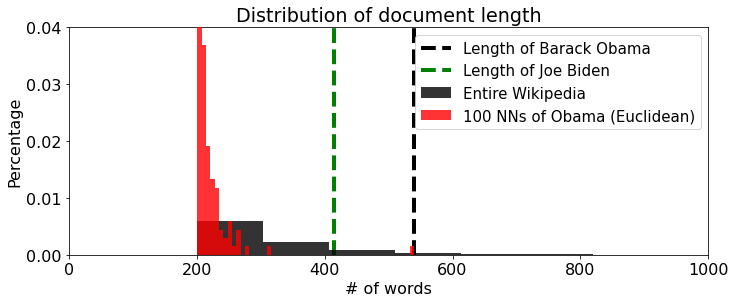

In [115]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=np.array(wiki[wiki['name'] == 'Barack Obama']['length']), color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=np.array(wiki[wiki['name'] == 'Joe Biden']['length']), color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Relative to the rest of Wikipedia, nearest neighbors of Obama are overwhemingly short, most of them being shorter than 300 words. The bias towards short articles is not appropriate in this application as there is really no reason to  favor short articles over long articles (they are all Wikipedia articles, after all). Many of the Wikipedia articles are 300 words or more, and both Obama and Biden are over 300 words long.

**Note**: For the interest of computation time, the dataset given here contains _excerpts_ of the articles rather than full text. For instance, the actual Wikipedia article about Obama is around 25000 words. Do not be surprised by the low numbers shown in the histogram.

**Note:** Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

Let us train a new nearest neighbor model, this time with cosine distances.  We then repeat the search for Obama's 100 nearest neighbors.

In [116]:
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine')
model2_tf_idf.fit(tf_idf)

distances, indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)

neighbours = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_cosine = neighbours.set_index('id').join(wiki).reset_index()[['id', 'name', 'length', 'distance']]
nearest_neighbors_cosine.sort_values(by='distance', inplace=True)
nearest_neighbors_cosine.head()

,id,name,length,distance
0,35817,Barack Obama,540,0.000000
1,24478,Joe Biden,414,0.703139
2,38376,Samantha Power,310,0.742982
3,57108,Hillary Rodham Clinton,580,0.758358
4,38714,Eric Stern (politician),255,0.770561


From a glance at the above table, things look better.  For example, we now see Joe Biden as Barack Obama's nearest neighbor!  We also see Hillary Clinton on the list.  This list looks even more plausible as nearest neighbors of Barack Obama.

Let's make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

<Figure size 756x324 with 0 Axes>

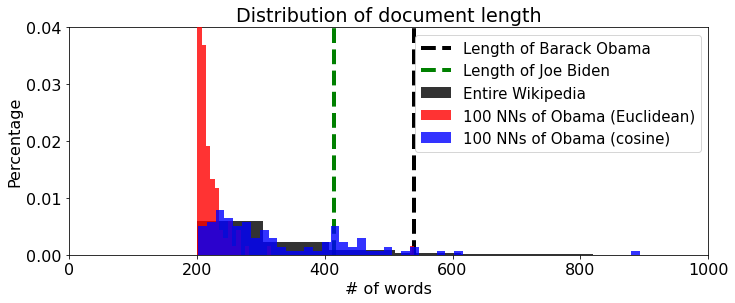

In [119]:
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=np.array(wiki[wiki['name'] == 'Barack Obama']['length']), color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=np.array(wiki[wiki['name'] == 'Joe Biden']['length']), color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, check if they produce results that make sense for your particular application.

# Problem with cosine distances: tweets vs. long articles

Happily ever after? Not so fast. Cosine distances ignore all document lengths, which may be great in certain situations but not in others. For instance, consider the following (admittedly contrived) example.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

How similar is this tweet to Barack Obama's Wikipedia article? Let's transform the tweet into TF-IDF features, using an encoder fit to the Wikipedia dataset.  (That is, let's treat this tweet as an article in our Wikipedia dataset and see what happens.)

In [120]:
tweet = {
    'act': 3.4597778278724887,
    'control': 3.721765211295327,
    'democratic': 3.1026721743330414,
    'governments': 4.167571323949673,
    'in': 0.0009654063501214492,
    'law': 2.4538226269605703,
    'popular': 2.764478952022998,
    'response': 4.261461747058352,
    'to': 0.04694493768179923
}

Let's look at the TF-IDF vectors for this tweet and for Barack Obama's Wikipedia entry, just to visually see their differences.

In [146]:
word_indices = [map_index_to_word.keys() == word for word in tweet.keys()]
tweet_tf_idf = csr_matrix( (list(tweet.values()), ([0]*len(word_indices), word_indices)),
                          shape=(1, tf_idf.shape[1]) )

Now, compute the cosine distance between the Barack Obama article and this tweet:

In [147]:
from sklearn.metrics.pairwise import cosine_distances

obama_tf_idf = tf_idf[35817]
print(cosine_distances(obama_tf_idf, tweet_tf_idf))

[[1.]]


Let's compare this distance to the distance between the Barack Obama article and all of its Wikipedia 10 nearest neighbors:

In [149]:
distances, indices = model2_tf_idf.kneighbors(obama_tf_idf, n_neighbors=10)

neighbours = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_cosine = neighbours.set_index('id').join(wiki).reset_index()[['id', 'name', 'length', 'distance']]
nearest_neighbors_cosine.sort_values(by='distance', inplace=True)
nearest_neighbors_cosine.head()

,id,name,length,distance
0,35817,Barack Obama,540,0.000000
1,24478,Joe Biden,414,0.703139
2,38376,Samantha Power,310,0.742982
3,57108,Hillary Rodham Clinton,580,0.758358
4,38714,Eric Stern (politician),255,0.770561


With cosine distances, the tweet is "nearer" to Barack Obama than everyone else, except for Joe Biden!  This probably is not something we want. If someone is reading the Barack Obama Wikipedia page, would you want to recommend they read this tweet? Ignoring article lengths completely resulted in nonsensical results. In practice, it is common to enforce maximum or minimum document lengths. After all, when someone is reading a long article from *The Atlantic*, you wouldn't recommend him/her a tweet.